In [1]:
import config
from entsoe import EntsoePandasClient
# 
import pandas as pd
import seaborn as sns
from datetime import datetime
# 
import sqlalchemy
from sqlalchemy import create_engine
from uuid import uuid4

# Retrieve Prices Data from API

In [2]:
API_KEY = config.API_KEY
client = EntsoePandasClient(api_key=API_KEY)

In [3]:
# INPUTS
from main import today_tomorrow_str_dates
yesterday_str, tomorrow_str = today_tomorrow_str_dates()
start = pd.Timestamp(yesterday_str, tz='Europe/Brussels')
end = pd.Timestamp(tomorrow_str, tz='Europe/Brussels')
country_code = 'BE'

In [4]:
prices = client.query_day_ahead_prices(country_code, start=start,end=end)
df_prices = pd.DataFrame({'date':prices.index, 'price':prices.values})
df_prices['date'] = pd.to_datetime(df_prices['date'])
df_prices['country_code'] = country_code
df_prices['unique_id'] = df_prices['date'].astype('int64') // 10**9
df_prices['unique_id'] = str(country_code) + df_prices['unique_id'].astype(str)
df_prices.set_index('unique_id',inplace=True)
df_prices.to_csv('prices.csv')

In [5]:
df_prices

,date,price,country_code
unique_id,,,
BE1668466800,2022-11-15 00:00:00+01:00,140.00,BE
BE1668470400,2022-11-15 01:00:00+01:00,131.53,BE
BE1668474000,2022-11-15 02:00:00+01:00,132.28,BE
BE1668477600,2022-11-15 03:00:00+01:00,112.57,BE
BE1668481200,2022-11-15 04:00:00+01:00,112.82,BE
BE1668484800,2022-11-15 05:00:00+01:00,131.37,BE
BE1668488400,2022-11-15 06:00:00+01:00,164.27,BE
BE1668492000,2022-11-15 07:00:00+01:00,212.18,BE
BE1668495600,2022-11-15 08:00:00+01:00,224.90,BE


<AxesSubplot:xlabel='date', ylabel='price'>

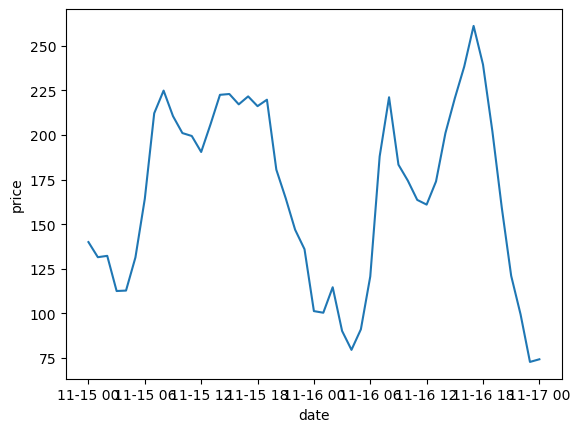

In [6]:
sns.lineplot(data=df_prices, x="date", y="price")

# Store Data in AWS RDS Database

In [7]:
HOST = config.HOST
USER = config.USER
PASSWORD = config.PASSWORD
DATABASE = config.DATABASE
PORT = config.PORT

In [8]:
db_connection_str = f'mysql+pymysql://{USER}:{PASSWORD}@{HOST}/{DATABASE}'
connection = create_engine(db_connection_str)

In [9]:

col_options = dict(
    dtype={
        'unique_id': sqlalchemy.types.VARCHAR(length=25),
        'date': sqlalchemy.types.DATETIME(),
        'price': sqlalchemy.types.FLOAT,
        'country_code': sqlalchemy.types.VARCHAR(length=25)
    }
)
table_name = 'prices-table'
index_name = 'unique_id'

In [10]:
try:
    df_prices.to_sql(name=table_name, con=connection, if_exists = 'append', index=True, index_label=index_name, **col_options)
    with connection.connect() as con:
        con.execute('ALTER TABLE `' + str(table_name) + '` ADD PRIMARY KEY (`'+ str(index_name) + '`);')
except Exception as e:
    print(e)
    for i in range(len(df_prices)):
        try:
            df_prices.iloc[i:i+1].to_sql(name=table_name, con=connection, if_exists = 'append')
        except Exception as e:
            print(i, e)
            pass

(pymysql.err.OperationalError) (1170, "BLOB/TEXT column 'unique_id' used in key specification without a key length")
[SQL: ALTER TABLE `prices-table` ADD PRIMARY KEY (`unique_id`);]
(Background on this error at: https://sqlalche.me/e/14/e3q8)
